In [87]:
# Data import
import pandas as pd
import numpy as np

used_car = pd.read_csv("used_cars.csv")
used_car.head(5)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [88]:
used_car.shape

(4009, 12)

### First, additional information can be extracted from the dataset. The following steps involve feature engineering, which will be applied before conducting EDA.

In [89]:
# Transform milage and price into numerical features
used_car['milage'] = used_car['milage'].str.replace(' mi.', '').str.replace(',', '').astype(int)
used_car['price'] = used_car['price'].str.replace('$', '').str.replace(',', '').astype('int64')

In [90]:
# Unify nan in fuel_type 
print(used_car["fuel_type"].unique())
used_car['fuel_type'] = used_car['fuel_type'].replace(['–', 'not supported'], np.nan)
print(used_car["fuel_type"].unique())

['E85 Flex Fuel' 'Gasoline' 'Hybrid' nan 'Diesel' 'Plug-In Hybrid' '–'
 'not supported']
['E85 Flex Fuel' 'Gasoline' 'Hybrid' nan 'Diesel' 'Plug-In Hybrid']


In [91]:
print(len(used_car["engine"].unique()))
print(len(used_car["transmission"].unique()))

1146
62


Both the "engine" and "transmission" columns are categorical variables with too many distinct categories, which limits their predictive usefulness in their current form. However, since both columns contain detailed descriptions as strings, valuable information can still be extracted. From the "engine" column, I can derive attributes such as horsepower, engine displacement, the number of cylinders, and whether the engine is turbocharged. Similarly, from the "transmission" column, I can extract whether it is automatic or manual and the number of gears.

In [92]:
# Extract horsepower from engine
def extract_horsepower(engine):
    match = pd.Series(engine).str.extract(r'(\d+\.?\d*)HP')
    return match[0] if not match.empty else np.nan

used_car['horsepower'] = used_car['engine'].apply(extract_horsepower).astype(float)

In [93]:
# Extract engine displacement from engine
def extract_displacement(engine):
    match = pd.Series(engine).str.extract(r'(\d+\.?\d*)\s*(L|Liter)')
    return match[0] if not match.empty else np.nan

used_car['displacement'] = used_car['engine'].apply(extract_displacement).astype(float)

In [94]:
# Extract cylinders from engine
def extract_cylinders(engine):
    match = pd.Series(engine).str.extract(r'(?:V|I)(\d+)|(\d+)\s*Cylinder')
    return match[0].combine_first(match[1]) if not match.empty else np.nan

used_car['cylinders'] = used_car['engine'].apply(extract_cylinders).astype(float)

In [95]:
# Determine whether an engine has turbo
def extract_turbo(engine):
    if "turbo" in engine.lower():
        return True
    else:
        return False
    
used_car['turbo'] = used_car['engine'].apply(extract_turbo)

In [96]:
unique_engines = used_car[['engine', 'horsepower', 'displacement', 'cylinders','turbo']].drop_duplicates()
display(unique_engines)

,engine,horsepower,displacement,cylinders,turbo
0,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,300.0,3.7,6.0,False
1,3.8L V6 24V GDI DOHC,NaN,3.8,6.0,False
2,3.5 Liter DOHC,NaN,3.5,NaN,False
3,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,354.0,3.5,6.0,False
4,2.0L I4 16V GDI DOHC Turbo,NaN,2.0,4.0,True
...,...,...,...,...,...
3942,400.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,400.0,5.0,8.0,False
3943,211.0HP 2.0L 4 Cylinder Engine Diesel Fuel,211.0,2.0,4.0,False
3974,136.0HP 1.8L 4 Cylinder Engine Gasoline Fuel,136.0,1.8,4.0,False
3977,270.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,270.0,2.0,4.0,False


In [97]:
# Classify Transmission into Automatic, Manual and Other
def classify_transmission(transmission):
    if "manual" in transmission.lower() or "m/t" in transmission.lower():
        return "Manual"
    elif "automatic" in transmission.lower() or "a/t" in transmission.lower():
        return "Automatic"
    else:
        return np.nan

used_car['transmission_type'] = used_car['transmission'].apply(classify_transmission)

In [98]:
# Create a new column num_gears by extracting the number of gears from transmission
def extract_gears(transmission):
    match = pd.Series(transmission).str.extract(r'(\d+)')
    return match[0] if not match.empty else np.nan

used_car['gears'] = used_car['transmission'].apply(extract_gears).astype(float)

In [99]:
# Check the transmission_type, and gears of each unique transformation
# pd.set_option('display.max_rows', None)
unique_transmissions = used_car[['transmission', 'transmission_type', 'gears']].drop_duplicates()
display(unique_transmissions)

,transmission,transmission_type,gears
0,6-Speed A/T,Automatic,6.0
1,8-Speed Automatic,Automatic,8.0
2,Automatic,Automatic,NaN
3,7-Speed A/T,Automatic,7.0
5,F,NaN,NaN
...,...,...,...
2393,9-Speed Automatic with Auto-Shift,Automatic,9.0
2620,SCHEDULED FOR OR IN PRODUCTION,NaN,NaN
2772,2-Speed A/T,Automatic,2.0
3206,6 Speed Mt,NaN,6.0


In [100]:
# Drop engine and transmission columns
used_car.drop(['engine', 'transmission', 'model', 'int_col', 'ext_col'], axis=1, inplace=True)

In [101]:
used_car.columns

Index(['brand', 'model_year', 'milage', 'fuel_type', 'accident', 'clean_title',
       'price', 'horsepower', 'displacement', 'cylinders', 'turbo',
       'transmission_type', 'gears'],
      dtype='object')

In [102]:
used_car.shape

(4009, 13)

### Next, we start the EDA procedures for the transformed dataset.

In [103]:
# dataset dimensions
used_car.shape

(4009, 13)

In [104]:
# Column data types
for col in used_car.columns:
    print(f"Column: {col}, Data type: {used_car[col].dtype}")

Column: brand, Data type: object
Column: model_year, Data type: int64
Column: milage, Data type: int64
Column: fuel_type, Data type: object
Column: accident, Data type: object
Column: clean_title, Data type: object
Column: price, Data type: int64
Column: horsepower, Data type: float64
Column: displacement, Data type: float64
Column: cylinders, Data type: float64
Column: turbo, Data type: bool
Column: transmission_type, Data type: object
Column: gears, Data type: float64


In [105]:
# Describe the target variable "sales price"
sales_price = used_car['price']
sales_price.describe()

count    4.009000e+03
mean     4.455319e+04
std      7.871064e+04
min      2.000000e+03
25%      1.720000e+04
50%      3.100000e+04
75%      4.999000e+04
max      2.954083e+06
Name: price, dtype: float64

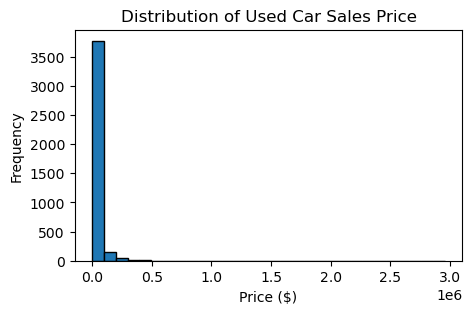

19.51355120421606


In [106]:
import matplotlib.pyplot as plt

# Histogram of sales_price
plt.figure(figsize=(5,3))
plt.hist(sales_price, bins=30, edgecolor='black')
plt.title("Distribution of Used Car Sales Price")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.show()

print(sales_price.skew())

This the skewness is significantly larger than 0, the target variable is right-skewed.

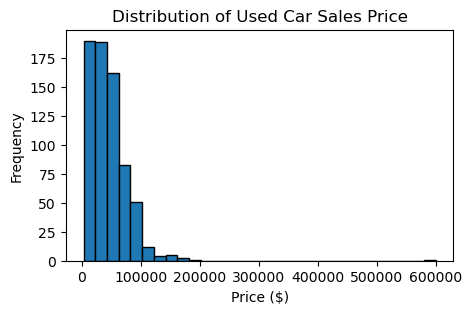

5.912025373385191


In [107]:
# Histogram of sales_price
used_car_no_gasoline = used_car[used_car['fuel_type'] != 'Gasoline']
plt.figure(figsize=(5,3))
plt.hist(used_car_no_gasoline['price'], bins=30, edgecolor='black')
plt.title("Distribution of Used Car Sales Price")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.show()

print(used_car_no_gasoline['price'].skew())

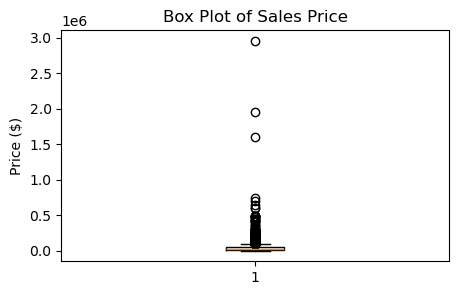

In [108]:
# Boxplot of sales_price
plt.figure(figsize=(5, 3))
plt.boxplot(sales_price)
plt.title('Box Plot of Sales Price')
plt.ylabel('Price ($)')
plt.show()

In [109]:
# reduce outliers
# Identify outliers based on the IQR method
Q1 = sales_price.quantile(0.25)
Q3 = sales_price.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
outliers = used_car[sales_price > upper_bound]

# Display the outliers
print(outliers)


              brand  model_year  milage fuel_type       accident clean_title  \
11            Aston        2019   22770  Gasoline  None reported         Yes   
16    Mercedes-Benz        2021    1685  Gasoline  None reported         Yes   
44            Lucid        2022    3552       NaN  None reported         Yes   
61             Audi        2018    8940  Gasoline  None reported         NaN   
71          Bentley        2017   14684  Gasoline  None reported         Yes   
...             ...         ...     ...       ...            ...         ...   
3964        Porsche        2022    2950  Gasoline  None reported         Yes   
3993        Porsche        2021    7008  Gasoline            NaN         NaN   
3994            BMW        2022   21057  Gasoline  None reported         Yes   
4002  Mercedes-Benz        2023    2000    Hybrid  None reported         Yes   
4004        Bentley        2023     714  Gasoline  None reported         Yes   

       price  horsepower  displacement 

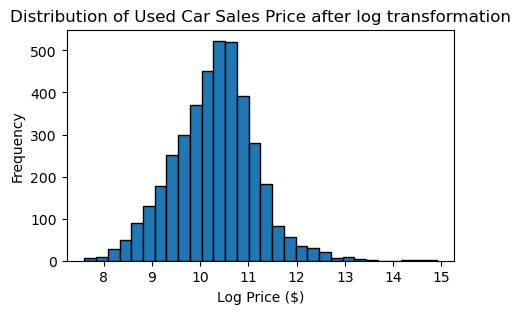

0.10559179534941941


In [110]:
# Log Transformation
used_car['sales_price_log'] = np.log(used_car['price'])
plt.figure(figsize=(5,3))
plt.hist(used_car['sales_price_log'], bins=30, edgecolor='black')
plt.title("Distribution of Used Car Sales Price after log transformation")
plt.xlabel("Log Price ($)")
plt.ylabel("Frequency")
plt.show()

print(used_car['sales_price_log'].skew())

In [111]:
used_car['sales_price_log'].describe()

count    4009.000000
mean       10.302352
std         0.850098
min         7.600902
25%         9.752665
50%        10.341742
75%        10.819578
max        14.898699
Name: sales_price_log, dtype: float64

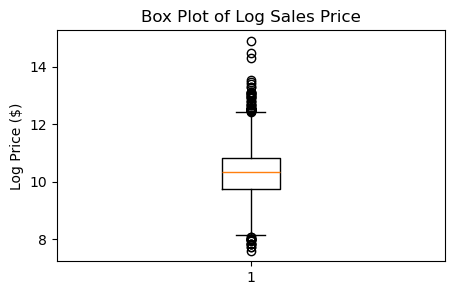

In [112]:
# Boxplot of log tranformed sales_price
plt.figure(figsize=(5, 3))
plt.boxplot(used_car['sales_price_log'])
plt.title('Box Plot of Log Sales Price')
plt.ylabel('Log Price ($)')
plt.show()

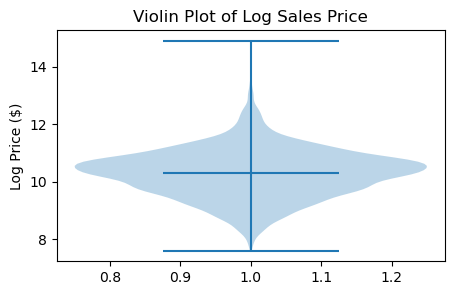

In [113]:
# Violinplot of log tranformed sales_price
plt.figure(figsize=(5, 3))
plt.violinplot(used_car['sales_price_log'], showmeans=True)
plt.title('Violin Plot of Log Sales Price')
plt.ylabel('Log Price ($)')
plt.show()

In [114]:
# Missing Value Detection
perc_missing_per_ftr = used_car.isnull().sum(axis=0) / used_car.shape[0]
print('Fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

print('Data types of the features with missing values:')
print(used_car[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)

frac_missing = sum(used_car.isnull().sum(axis=1) != 0) / used_car.shape[0]
print('Fraction of points with missing values:', frac_missing)

Fraction of missing values in features:
fuel_type            0.054128
accident             0.028187
clean_title          0.148666
horsepower           0.201547
displacement         0.054128
cylinders            0.109753
transmission_type    0.121976
gears                0.457221
dtype: float64
Data types of the features with missing values:
fuel_type             object
accident              object
clean_title           object
horsepower           float64
displacement         float64
cylinders            float64
transmission_type     object
gears                float64
dtype: object
Fraction of points with missing values: 0.6083811424295336


### Some Categorical vs Continuous Plots

/home/lshiyu/anaconda3/envs/data1030_env/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


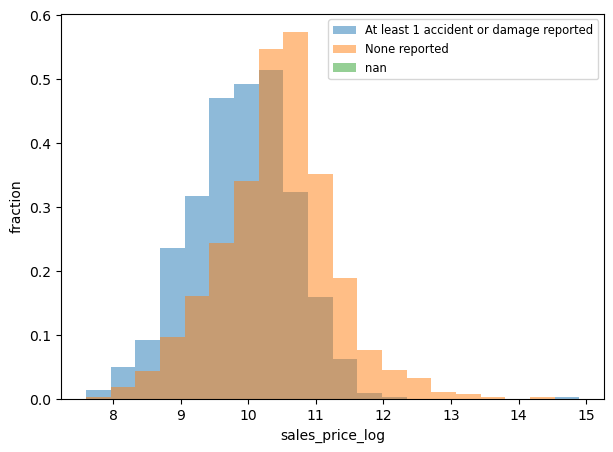

In [115]:
# Accident vs log sales price
categories = used_car['accident'].unique()
bin_range = (used_car['sales_price_log'].min(),used_car['sales_price_log'].max())

plt.figure(figsize=(7,5))

for c in categories:
    plt.hist(used_car[used_car['accident']==c]['sales_price_log'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend(fontsize='small')
plt.ylabel('fraction')
plt.xlabel('sales_price_log')
plt.show()

/home/lshiyu/anaconda3/envs/data1030_env/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


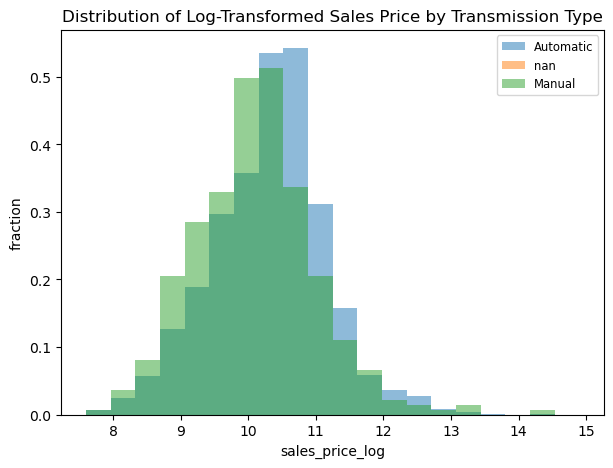

In [129]:
# Transmission type vs log sales price
categories = used_car['transmission_type'].unique()
bin_range = (used_car['sales_price_log'].min(),used_car['sales_price_log'].max())

plt.figure(figsize=(7,5))

for c in categories:
    plt.hist(used_car[used_car['transmission_type']==c]['sales_price_log'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend(fontsize='small')
plt.title("Distribution of Log-Transformed Sales Price by Transmission Type")
plt.ylabel('fraction')
plt.xlabel('sales_price_log')
plt.show()

<Figure size 700x500 with 0 Axes>

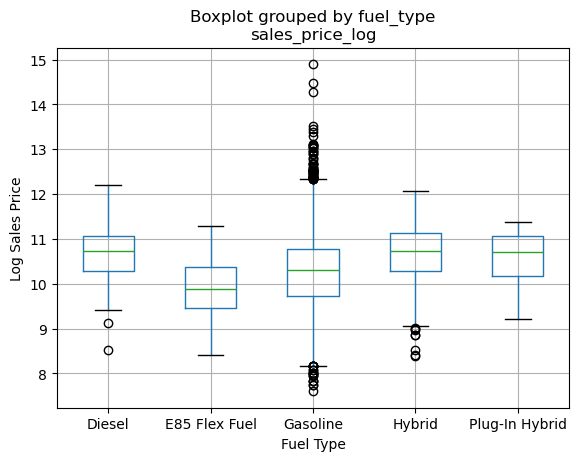

In [116]:
plt.figure(figsize=(7,5))

used_car[['sales_price_log','fuel_type']].boxplot(by='fuel_type')

plt.ylabel('Log Sales Price')
plt.xlabel('Fuel Type')
plt.show()

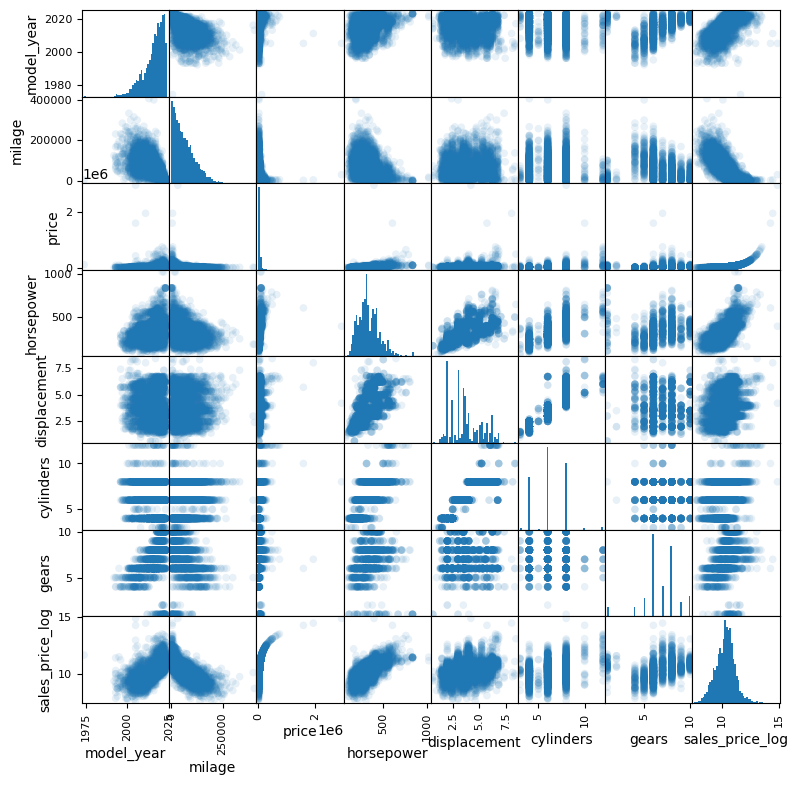

In [117]:
pd.plotting.scatter_matrix(used_car.select_dtypes("number"), figsize=(9, 9), marker='o',hist_kwds={'bins': 50}, 
                           s=30, alpha=.1)
plt.show()

### Finally, we start the splitting and preprocessing procedures

In [118]:
# Data types of features
for column in used_car.columns:
    print(f"Column: {column}, Data Type: {used_car[column].dtype}")

Column: brand, Data Type: object
Column: model_year, Data Type: int64
Column: milage, Data Type: int64
Column: fuel_type, Data Type: object
Column: accident, Data Type: object
Column: clean_title, Data Type: object
Column: price, Data Type: int64
Column: horsepower, Data Type: float64
Column: displacement, Data Type: float64
Column: cylinders, Data Type: float64
Column: turbo, Data Type: bool
Column: transmission_type, Data Type: object
Column: gears, Data Type: float64
Column: sales_price_log, Data Type: float64


In [119]:
# Import split and preprocessing packages
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [120]:
# Split
random_state = 42

y = used_car['sales_price_log']
X = used_car.drop(['price', 'sales_price_log'], axis=1)
print(X.shape)

X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.6, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=random_state)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(4009, 12)
(2405, 12)
(802, 12)
(802, 12)


In [121]:
# Group features into numerical and categorical variables
num_ftrs = ['model_year', 'milage', 'horsepower', 'displacement', 'cylinders', 'turbo', 'gears']
cat_ftrs = ['brand', 'fuel_type', 'accident', 'clean_title', 'transmission_type']

In [122]:
# Preprocess
# one-hot encoder for categorical features
categorical_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),  # doesn't need
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# standard scaler for numerical variables
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs)])

In [123]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# the feature names after fit
feature_names = preprocessor.get_feature_names_out()

# you can convert the numpy array back to a data frame with the feature names if you want
df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(df_train.shape)

# transform the CV
df_val = preprocessor.transform(X_val)
df_val = pd.DataFrame(data=df_val,columns = feature_names)
print(df_val.shape)

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(df_test.shape)
print(feature_names)

(2405, 75)
(802, 75)
(802, 75)
['num__model_year' 'num__milage' 'num__horsepower' 'num__displacement'
 'num__cylinders' 'num__turbo' 'num__gears' 'cat__brand_Acura'
 'cat__brand_Alfa' 'cat__brand_Aston' 'cat__brand_Audi' 'cat__brand_BMW'
 'cat__brand_Bentley' 'cat__brand_Buick' 'cat__brand_Cadillac'
 'cat__brand_Chevrolet' 'cat__brand_Chrysler' 'cat__brand_Dodge'
 'cat__brand_FIAT' 'cat__brand_Ferrari' 'cat__brand_Ford' 'cat__brand_GMC'
 'cat__brand_Genesis' 'cat__brand_Honda' 'cat__brand_Hummer'
 'cat__brand_Hyundai' 'cat__brand_INFINITI' 'cat__brand_Jaguar'
 'cat__brand_Jeep' 'cat__brand_Karma' 'cat__brand_Kia'
 'cat__brand_Lamborghini' 'cat__brand_Land' 'cat__brand_Lexus'
 'cat__brand_Lincoln' 'cat__brand_Lotus' 'cat__brand_Lucid'
 'cat__brand_MINI' 'cat__brand_Maserati' 'cat__brand_Mazda'
 'cat__brand_McLaren' 'cat__brand_Mercedes-Benz' 'cat__brand_Mercury'
 'cat__brand_Mitsubishi' 'cat__brand_Nissan' 'cat__brand_Polestar'
 'cat__brand_Pontiac' 'cat__brand_Porsche' 'cat__brand_RAM'

In [124]:
# Missing Value After transformation
print('data dimensions:',df_train.shape)
perc_missing_per_ftr = df_train.isnull().sum(axis=0)/df_train.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df_train[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df_train.isnull().sum(axis=1)!=0)/df_train.shape[0]
print('fraction of points with missing values:',frac_missing)

data dimensions: (2405, 75)
fraction of missing values in features:
num__horsepower      0.200416
num__displacement    0.050728
num__cylinders       0.111435
num__gears           0.456549
dtype: float64
data types of the features with missing values:
num__horsepower      float64
num__displacement    float64
num__cylinders       float64
num__gears           float64
dtype: object
fraction of points with missing values: 0.59002079002079


In [131]:
# Check missing values for each feature (column) in the training set
perc_missing_per_ftr_train = df_train.isnull().sum(axis=0) / df_train.shape[0]
print('Proportion of missing values per feature in the training set:')
print(perc_missing_per_ftr_train[perc_missing_per_ftr_train > 0])

# Check the proportion of rows with missing values in the training set
frac_missing_train = (df_train.isnull().sum(axis=1) != 0).mean()
print('Proportion of rows with missing values in the training set:', frac_missing_train)

# Repeat for validation set
perc_missing_per_ftr_val = df_val.isnull().sum(axis=0) / df_val.shape[0]
print('Proportion of missing values per feature in the validation set:')
print(perc_missing_per_ftr_val[perc_missing_per_ftr_val > 0])

frac_missing_val = (df_val.isnull().sum(axis=1) != 0).mean()
print('Proportion of rows with missing values in the validation set:', frac_missing_val)

# Repeat for test set
perc_missing_per_ftr_test = df_test.isnull().sum(axis=0) / df_test.shape[0]
print('Proportion of missing values per feature in the test set:')
print(perc_missing_per_ftr_test[perc_missing_per_ftr_test > 0])

frac_missing_test = (df_test.isnull().sum(axis=1) != 0).mean()
print('Proportion of rows with missing values in the test set:', frac_missing_test)


Proportion of missing values per feature in the training set:
num__horsepower      0.200416
num__displacement    0.050728
num__cylinders       0.111435
num__gears           0.456549
dtype: float64
Proportion of rows with missing values in the training set: 0.59002079002079
Proportion of missing values per feature in the validation set:
num__horsepower      0.209476
num__displacement    0.061097
num__cylinders       0.108479
num__gears           0.441397
dtype: float64
Proportion of rows with missing values in the validation set: 0.5922693266832918
Proportion of missing values per feature in the test set:
num__horsepower      0.197007
num__displacement    0.057357
num__cylinders       0.105985
num__gears           0.475062
dtype: float64
Proportion of rows with missing values in the test set: 0.6159600997506235


In [132]:
# Concatenate the training, validation, and test sets
df_combined = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Calculate the proportion of missing values per feature across all datasets
perc_missing_per_ftr_combined = df_combined.isnull().sum(axis=0) / df_combined.shape[0]
print('Proportion of missing values per feature across all sets:')
print(perc_missing_per_ftr_combined[perc_missing_per_ftr_combined > 0])

# Calculate the proportion of rows with missing values across all datasets
frac_missing_combined = (df_combined.isnull().sum(axis=1) != 0).mean()
print('Proportion of rows with missing values across all sets:', frac_missing_combined)


Proportion of missing values per feature across all sets:
num__horsepower      0.201547
num__displacement    0.054128
num__cylinders       0.109753
num__gears           0.457221
dtype: float64
Proportion of rows with missing values across all sets: 0.595659765527563


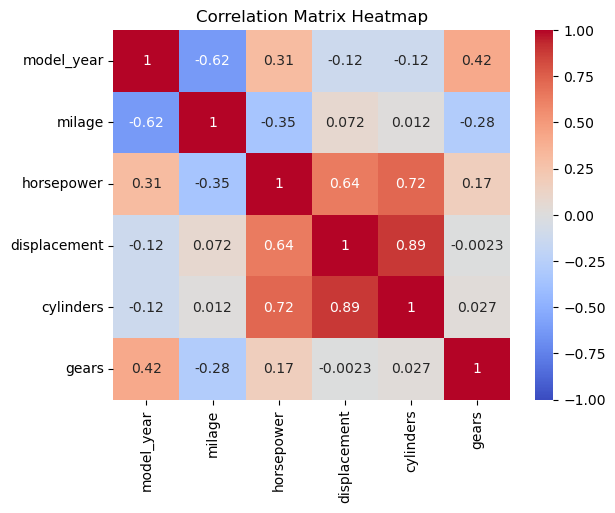

In [125]:
import seaborn as sns

numeric_df = used_car.drop(['price', 'sales_price_log'], axis=1).select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

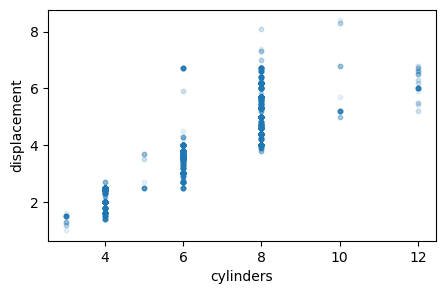

In [126]:
used_car.plot.scatter('cylinders','displacement',figsize=(5,3),alpha=0.1,s=10)
plt.show()

In [127]:
used_car['clean_title'].unique()

array(['Yes', nan], dtype=object)

In [130]:
used_car[used_car['fuel_type'] == 'Hybrid'].sort_values(by='price', ascending=True)

,brand,model_year,milage,fuel_type,accident,clean_title,price,horsepower,displacement,cylinders,turbo,transmission_type,gears,sales_price_log
2787,Saturn,2009,115000,Hybrid,None reported,Yes,4400,172.0,2.4,4.0,False,Automatic,NaN,8.389360
3414,Ford,2011,223824,Hybrid,At least 1 accident or damage reported,Yes,4500,156.0,2.5,4.0,False,Automatic,NaN,8.411833
499,Toyota,2006,264893,Hybrid,At least 1 accident or damage reported,Yes,5000,208.0,3.3,6.0,False,Automatic,NaN,8.517193
1580,Toyota,2009,142500,Hybrid,None reported,Yes,6999,76.0,1.5,4.0,False,Automatic,NaN,8.853523
1023,Lexus,2012,239000,Hybrid,None reported,Yes,7000,295.0,3.5,6.0,False,Automatic,NaN,8.853665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,Land,2023,3534,Hybrid,None reported,NaN,143998,NaN,4.4,NaN,False,Automatic,NaN,11.877555
306,Mercedes-Benz,2022,4102,Hybrid,None reported,Yes,144664,603.0,4.0,8.0,False,Automatic,9.0,11.882169
1955,Land,2023,4126,Hybrid,NaN,NaN,155000,395.0,3.0,6.0,False,Automatic,NaN,11.951180
1129,Audi,2022,4100,Hybrid,None reported,Yes,162500,591.0,4.0,8.0,False,Automatic,8.0,11.998433
